In [1]:
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from catboost import CatBoostRegressor
from lager.ml_forecasters.simple_forecaster import SimpleForecaster
from lager.baseline_forecasters.baseline_forecast import get_baseline_forecast_simple
from lager.auto_ml_forecasters.auto_forecaster import AutoForecaster
from lager.ml_forecasters.multidim_simple_forecaster import MultiDimSimpleForecaster
%matplotlib inline

In [2]:
data=pd.read_csv('../data/household_power_consumption.txt', delimiter=';', low_memory=False).dropna(how='any')
for x in ['Date', 'Time', 'Global_intensity']:
    del data[x]
data=data.rename(columns={'Global_active_power': 'target',
            'Global_reactive_power': 'reactive',
             'Voltage': 'voltage',
             'Sub_metering_1': 's1',
            'Sub_metering_2': 's2',
            'Sub_metering_3': 's3'})
data=data.astype(float)

In [3]:
data

,target,reactive,voltage,s1,s2,s3
0,4.216,0.418,234.84,0.0,1.0,17.0
1,5.360,0.436,233.63,0.0,1.0,16.0
2,5.374,0.498,233.29,0.0,2.0,17.0
3,5.388,0.502,233.74,0.0,1.0,17.0
4,3.666,0.528,235.68,0.0,1.0,17.0
...,...,...,...,...,...,...
2075254,0.946,0.000,240.43,0.0,0.0,0.0
2075255,0.944,0.000,240.00,0.0,0.0,0.0
2075256,0.938,0.000,239.82,0.0,0.0,0.0
2075257,0.934,0.000,239.70,0.0,0.0,0.0


In [4]:
data.corr()

,target,reactive,voltage,s1,s2,s3
target,1.000000,0.247017,-0.399762,0.484401,0.434569,0.638555
reactive,0.247017,1.000000,-0.112246,0.123111,0.139231,0.089617
voltage,-0.399762,-0.112246,1.000000,-0.195976,-0.167405,-0.268172
s1,0.484401,0.123111,-0.195976,1.000000,0.054721,0.102571
s2,0.434569,0.139231,-0.167405,0.054721,1.000000,0.080872
s3,0.638555,0.089617,-0.268172,0.102571,0.080872,1.000000


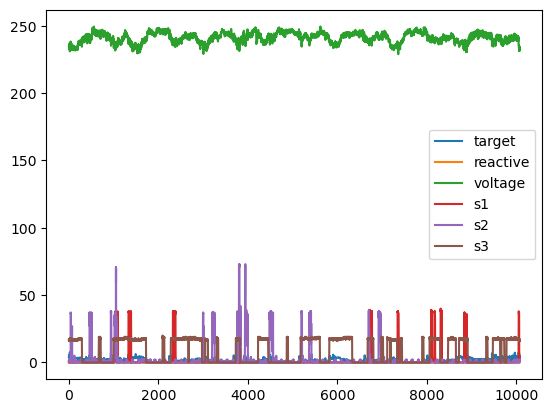

In [5]:
series = data[:60*24*7]
val_series = data[60*24*7:60*24*7+60*24]
series.plot();

## MultiDimSimpleForecaster

In [6]:
M = MultiDimSimpleForecaster(df=series, future_df=val_series)

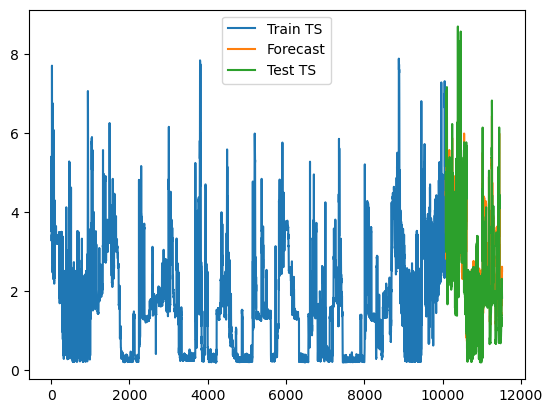

0.8766888265470966

In [7]:
M.forecast();
M.plot()
M.get_metric()

In [8]:
get_baseline_forecast_simple(ts_train=np.array(series['target']), ts_test=np.array(val_series['target']))

1.0001884527777778

## SimpleForecaster

In [9]:
regressor = CatBoostRegressor(silent=True)
S=SimpleForecaster(ts=np.array(series['target']), future_ts=np.array(val_series['target']), num_features=3,
                  regressor=regressor)

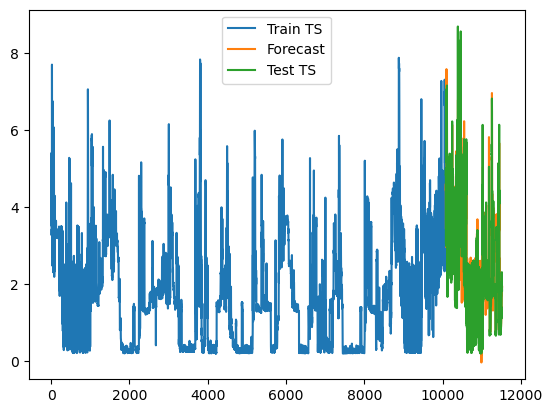

0.8316906668329522

In [10]:
S.forecast();
S.plot()
S.get_metric()

## AutoForecaster

In [11]:
num_features=[3, 4, 5, 10, 15, 60]

In [12]:
A = AutoForecaster(ts=np.array(series['target']), 
                   model_type='simple', 
                   num_features=num_features, 
                   train_size=60*24*2,
                   test_size=60*24)

In [13]:
%%time
A.get_best_model()

RandomForestRegressor 3
RandomForestRegressor 4
RandomForestRegressor 5
RandomForestRegressor 10
RandomForestRegressor 15
RandomForestRegressor 60
LGBMRegressor 3
LGBMRegressor 4
LGBMRegressor 5
LGBMRegressor 10
LGBMRegressor 15
LGBMRegressor 60
DecisionTreeRegressor 3
DecisionTreeRegressor 4
DecisionTreeRegressor 5
DecisionTreeRegressor 10
DecisionTreeRegressor 15
DecisionTreeRegressor 60
LinearRegression 3
LinearRegression 4
LinearRegression 5
LinearRegression 10
LinearRegression 15
LinearRegression 60
Best regressor LinearRegression() with 4 num_features; value of mse metric is 0.2100283043536501
CPU times: user 16min 31s, sys: 7.98 s, total: 16min 39s
Wall time: 3min 21s


In [14]:
A.get_validation_value(ts_val=np.array(val_series['target']))

Baseline metric: 1.0001884527777778; regressor average metric after 10 trials: 1.050739765619632.


1.050739765619632